This notebook explains how we can use TDA as image analysis tools.

We are planning to add examples to make this a concise reference for incorporating TDA into image analysis framework.

A link to the paper with more detailed explanations will appear here once it is made available.

In [1]:
import cv2
import homcloud.interface as hc
import numpy as np
import matplotlib.pyplot as plt
import copy
from skimage.color import label2rgb

We start with the simplest example of figure detection.

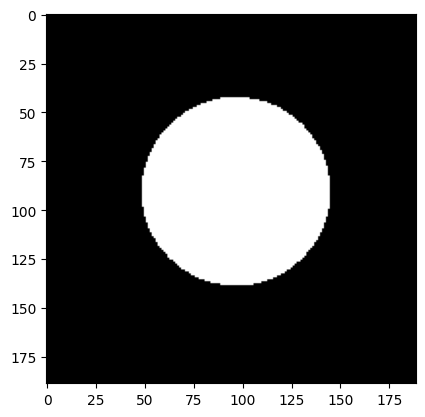

In [2]:
img = cv2.imread('figure1.png', cv2.IMREAD_GRAYSCALE)
ret, img_binary = cv2.threshold(img, 60, 255,cv2.THRESH_BINARY)
plt.imshow(img_binary,cmap='gray')
plt.show()

In [3]:
####filtration using signed distance transform
hc.PDList.from_bitmap_levelset(hc.distance_transform(img_binary>100, signed=True), save_to="binary-image.pdgm")

PDList(path=binary-image.pdgm)

In [5]:
pdlist = hc.PDList("binary-image.pdgm")

In [7]:
pd = pdlist.dth_diagram(0)
pd.pairs()

[]

In [10]:
####The figure is detected in the essential birth position.
pd.essential_birth_positions

[[90, 96]]

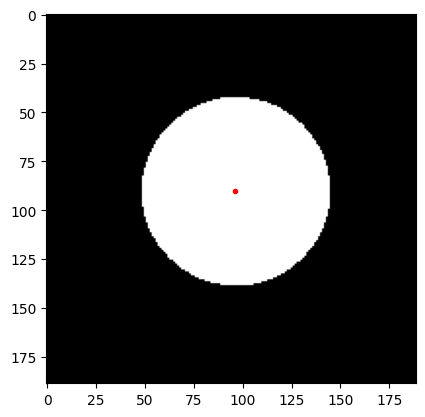

In [14]:
plt.imshow(img_binary,cmap='gray')
plt.plot(pd.essential_birth_positions[0][1],pd.essential_birth_positions[0][0],marker='.',color='red')
plt.show()

In [29]:
####Alpha complex filtration using the points on the contour
contours, hierarchy = cv2.findContours(img_binary, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)#Detecting boundaries.
pointcloud=np.array([contours[0][t][0].tolist() for t in range (0,len(contours[0]))])
np.random.seed(23)
pointcloud_noise=pointcloud+np.random.uniform(0,0.1,(len(pointcloud),2))
hc.PDList.from_alpha_filtration(pointcloud_noise,save_to="pointcloud.pdgm",save_boundary_map=True,no_squared=True)#Calculating persistent homology.

PDList(path=pointcloud.pdgm)

In [30]:
pdlist = hc.PDList("pointcloud.pdgm")
pd = pdlist.dth_diagram(1)
pairs=pd.pairs()

In [31]:
pairs

[Pair(0.7461608599172896, 47.21490604508272)]

96.67333741665846 90.68121331037453


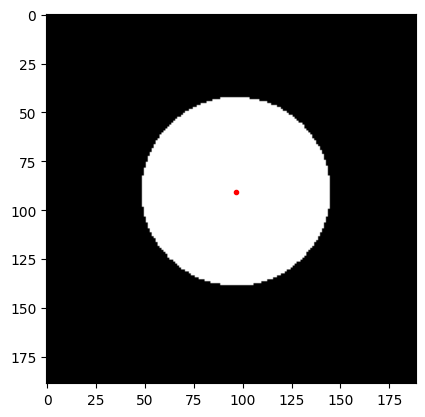

In [33]:
P=pairs[0].death_position
####Calculate the circumcenter of the death positions.
x=((P[0][0]**2+P[0][1]**2)*(P[1][1]-P[2][1])+(P[1][0]**2+P[1][1]**2)*(P[2][1]-P[0][1])+(P[2][0]**2+P[2][1]**2)*(P[0][1]-P[1][1]))/(2*(P[0][0]*(P[1][1]-P[2][1])+P[1][0]*(P[2][1]-P[0][1])+P[2][0]*(P[0][1]-P[1][1])))
y=((P[0][0]**2+P[0][1]**2)*(P[2][0]-P[1][0])+(P[1][0]**2+P[1][1]**2)*(P[0][0]-P[2][0])+(P[2][0]**2+P[2][1]**2)*(P[1][0]-P[0][0]))/(2*(P[0][0]*(P[1][1]-P[2][1])+P[1][0]*(P[2][1]-P[0][1])+P[2][0]*(P[0][1]-P[1][1])))
print(x,y)
plt.imshow(img_binary,cmap='gray')
plt.plot(x,y,marker='.',color='red')
plt.show()

Both of the two approaches work as we expect.

Next, we will deal with the overlapping figure detection.

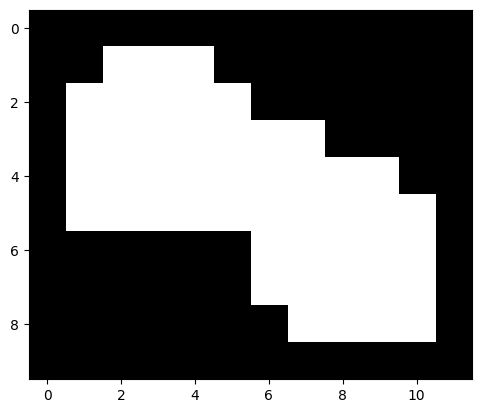

In [34]:
overlapping_figures=np.array([[0,0,0,0,0,0,0,0,0,0,0,0],
                              [0,0,1,1,1,0,0,0,0,0,0,0],
                              [0,1,1,1,1,1,0,0,0,0,0,0],
                              [0,1,1,1,1,1,1,1,0,0,0,0],
                              [0,1,1,1,1,1,1,1,1,1,0,0],
                              [0,1,1,1,1,1,1,1,1,1,1,0],
                              [0,0,0,0,0,0,1,1,1,1,1,0],
                              [0,0,0,0,0,0,1,1,1,1,1,0],
                              [0,0,0,0,0,0,0,1,1,1,1,0],
                              [0,0,0,0,0,0,0,0,0,0,0,0]])
plt.imshow(overlapping_figures,cmap='gray')
plt.show()

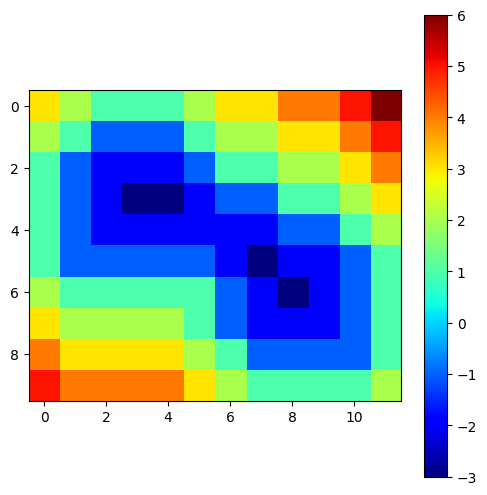

In [62]:
fig, ax = plt.subplots(figsize=(6,6))
im = ax.imshow(hc.distance_transform(overlapping_figures>0.5, signed=True), cmap='jet')
cbar = fig.colorbar(im)
plt.show()

In [53]:
####filtration using signed distance transform
hc.PDList.from_bitmap_levelset(hc.distance_transform(overlapping_figures>0.5, signed=True), save_to="binary-image.pdgm")
pdlist = hc.PDList("binary-image.pdgm")
pd = pdlist.dth_diagram(0)
pd.pairs()

[Pair(-3.0, -2.0), Pair(-3.0, -2.0)]

In [54]:
for pair in pd.pairs():
    print(pair.birth_position)

[5, 7]
[6, 8]


In [55]:
pd.essential_births,pd.essential_birth_positions

(array([-3.]), [[3, 3]])

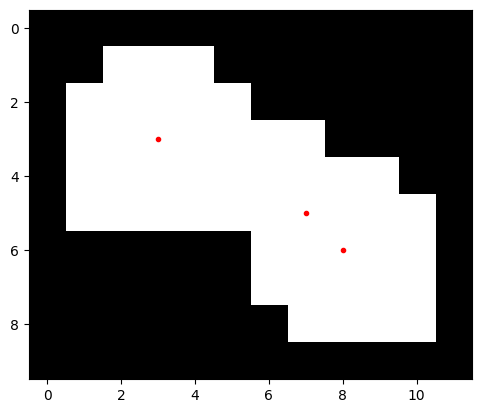

In [56]:
plt.imshow(overlapping_figures,cmap='gray')
for pair in pd.pairs():
    plt.plot(pair.birth_position[1],pair.birth_position[0],marker='.',color='red')
plt.plot(pd.essential_birth_positions[0][1],pd.essential_birth_positions[0][0],marker='.',color='red')
plt.show()

The resolution of this filtration is integer. You can detect one figure (the whole structure as one structure) or three figures.

The two figures (in the non-essential pairs) are undistinguishable using size (death) or persistence.

In [100]:
####Alpha complex filtration using the points on the contour
contours, hierarchy = cv2.findContours(overlapping_figures.astype('uint8'), cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)#Detecting boundaries.
pointcloud=np.array([contours[0][t][0].tolist() for t in range (0,len(contours[0]))])
np.random.seed(23)
pointcloud_noise=pointcloud+np.random.uniform(0,0.1,(len(pointcloud),2))
hc.PDList.from_alpha_filtration(pointcloud_noise,save_to="pointcloud.pdgm",save_boundary_map=True,no_squared=True)#Calculating persistent homology.

PDList(path=pointcloud.pdgm)

In [65]:
pdlist = hc.PDList("pointcloud.pdgm")
pd = pdlist.dth_diagram(1)
pairs=pd.pairs()

In [66]:
pairs

[Pair(0.7089067928723765, 0.7089585578486304),
 Pair(1.4003341793574409, 1.5421527329143074),
 Pair(1.9673361195620371, 1.968859901834341),
 Pair(1.0917741072011469, 1.9805758816790127),
 Pair(0.7352263181638518, 1.9840991021827918)]

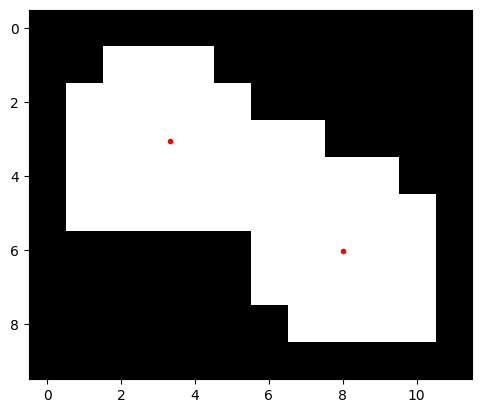

In [67]:
plt.imshow(overlapping_figures,cmap='gray')
for w in range (0,len(pairs)):
    if pairs[w].death_time()-pairs[w].birth_time()>0.5:
        P=pairs[w].death_position
        x=((P[0][0]**2+P[0][1]**2)*(P[1][1]-P[2][1])+(P[1][0]**2+P[1][1]**2)*(P[2][1]-P[0][1])+(P[2][0]**2+P[2][1]**2)*(P[0][1]-P[1][1]))/(2*(P[0][0]*(P[1][1]-P[2][1])+P[1][0]*(P[2][1]-P[0][1])+P[2][0]*(P[0][1]-P[1][1])))
        y=((P[0][0]**2+P[0][1]**2)*(P[2][0]-P[1][0])+(P[1][0]**2+P[1][1]**2)*(P[0][0]-P[2][0])+(P[2][0]**2+P[2][1]**2)*(P[1][0]-P[0][0]))/(2*(P[0][0]*(P[1][1]-P[2][1])+P[1][0]*(P[2][1]-P[0][1])+P[2][0]*(P[0][1]-P[1][1])))
        plt.plot(x,y,marker='.',color='red')
plt.show()

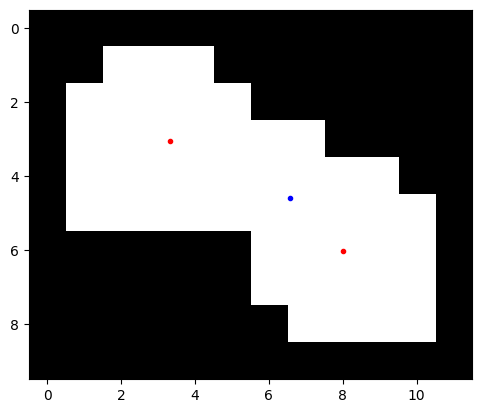

In [69]:
plt.imshow(overlapping_figures,cmap='gray')
for w in range (0,len(pairs)):
    if pairs[w].death_time()-pairs[w].birth_time()>0.1:
        if pairs[w].death_time()>1.8:
            P=pairs[w].death_position
            x=((P[0][0]**2+P[0][1]**2)*(P[1][1]-P[2][1])+(P[1][0]**2+P[1][1]**2)*(P[2][1]-P[0][1])+(P[2][0]**2+P[2][1]**2)*(P[0][1]-P[1][1]))/(2*(P[0][0]*(P[1][1]-P[2][1])+P[1][0]*(P[2][1]-P[0][1])+P[2][0]*(P[0][1]-P[1][1])))
            y=((P[0][0]**2+P[0][1]**2)*(P[2][0]-P[1][0])+(P[1][0]**2+P[1][1]**2)*(P[0][0]-P[2][0])+(P[2][0]**2+P[2][1]**2)*(P[1][0]-P[0][0]))/(2*(P[0][0]*(P[1][1]-P[2][1])+P[1][0]*(P[2][1]-P[0][1])+P[2][0]*(P[0][1]-P[1][1])))
            plt.plot(x,y,marker='.',color='red')
        else:
            P=pairs[w].death_position
            x=((P[0][0]**2+P[0][1]**2)*(P[1][1]-P[2][1])+(P[1][0]**2+P[1][1]**2)*(P[2][1]-P[0][1])+(P[2][0]**2+P[2][1]**2)*(P[0][1]-P[1][1]))/(2*(P[0][0]*(P[1][1]-P[2][1])+P[1][0]*(P[2][1]-P[0][1])+P[2][0]*(P[0][1]-P[1][1])))
            y=((P[0][0]**2+P[0][1]**2)*(P[2][0]-P[1][0])+(P[1][0]**2+P[1][1]**2)*(P[0][0]-P[2][0])+(P[2][0]**2+P[2][1]**2)*(P[1][0]-P[0][0]))/(2*(P[0][0]*(P[1][1]-P[2][1])+P[1][0]*(P[2][1]-P[0][1])+P[2][0]*(P[0][1]-P[1][1])))
            plt.plot(x,y,marker='.',color='blue')
plt.show()

We can distinguish figures using size or persistence with alpha filtration.

We can use these detected points as the markers for watershed method.

Alternatively, we can use birth simplex to divide the image into connected components.

See https://github.com/TopologicalBird/Persistent_Homological_Figure_Detection_Segmentation

for details.                               

Next, we deal with disconnected contours.

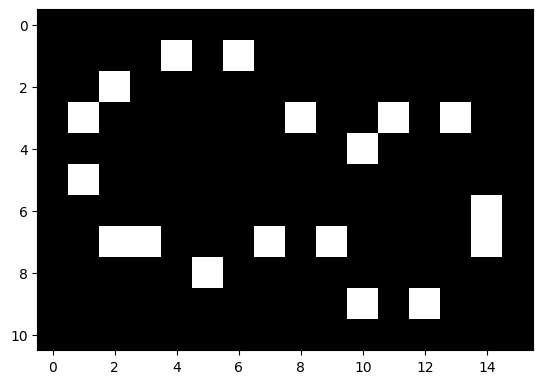

In [88]:
disconnected_img=np.array([[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
                          [0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0],
                          [0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0],
                          [0,1,0,0,0,0,0,0,1,0,0,1,0,1,0,0],
                          [0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0],
                          [0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
                          [0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0],
                          [0,0,1,1,0,0,0,1,0,1,0,0,0,0,1,0],
                          [0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0],
                          [0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0],
                          [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]])
plt.imshow(disconnected_img,cmap='gray')
plt.show()

In [116]:
####alpha complex filtration
pointcloud=np.transpose(np.array([np.where(disconnected_img)[0],np.where(disconnected_img)[1]]))

In [117]:
hc.PDList.from_alpha_filtration(pointcloud,save_to="pointcloud.pdgm",save_boundary_map=True,no_squared=True)#Calculating persistent homology.

PDList(path=pointcloud.pdgm)

In [118]:
pdlist = hc.PDList("pointcloud.pdgm")
pd = pdlist.dth_diagram(1)
pairs=pd.pairs()

In [119]:
pairs

[Pair(2.0615528128088303, 2.125),
 Pair(1.5811388300841898, 2.575393768188564),
 Pair(1.5811388300841898, 3.3496886722773853)]

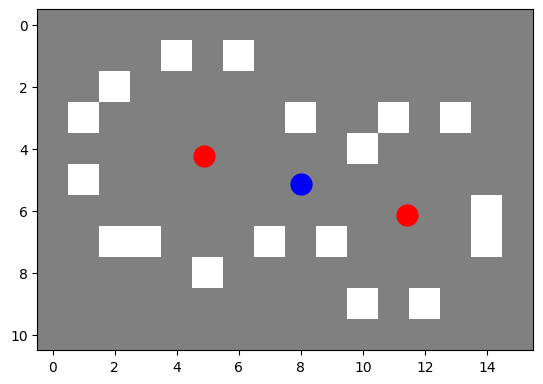

In [120]:
####x and y are inverted compared to the previous examples using cv2.findcontours
plt.imshow(disconnected_img,cmap='gray',alpha=0.5)
for w in range (0,len(pairs)):
    if pairs[w].death_time()-pairs[w].birth_time()>0.1:
        P=pairs[w].death_position
        x=((P[0][0]**2+P[0][1]**2)*(P[1][1]-P[2][1])+(P[1][0]**2+P[1][1]**2)*(P[2][1]-P[0][1])+(P[2][0]**2+P[2][1]**2)*(P[0][1]-P[1][1]))/(2*(P[0][0]*(P[1][1]-P[2][1])+P[1][0]*(P[2][1]-P[0][1])+P[2][0]*(P[0][1]-P[1][1])))
        y=((P[0][0]**2+P[0][1]**2)*(P[2][0]-P[1][0])+(P[1][0]**2+P[1][1]**2)*(P[0][0]-P[2][0])+(P[2][0]**2+P[2][1]**2)*(P[1][0]-P[0][0]))/(2*(P[0][0]*(P[1][1]-P[2][1])+P[1][0]*(P[2][1]-P[0][1])+P[2][0]*(P[0][1]-P[1][1])))
        plt.plot(y,x,marker='.',color='red',markersize=30)
    else:
        P=pairs[w].death_position
        x=((P[0][0]**2+P[0][1]**2)*(P[1][1]-P[2][1])+(P[1][0]**2+P[1][1]**2)*(P[2][1]-P[0][1])+(P[2][0]**2+P[2][1]**2)*(P[0][1]-P[1][1]))/(2*(P[0][0]*(P[1][1]-P[2][1])+P[1][0]*(P[2][1]-P[0][1])+P[2][0]*(P[0][1]-P[1][1])))
        y=((P[0][0]**2+P[0][1]**2)*(P[2][0]-P[1][0])+(P[1][0]**2+P[1][1]**2)*(P[0][0]-P[2][0])+(P[2][0]**2+P[2][1]**2)*(P[1][0]-P[0][0]))/(2*(P[0][0]*(P[1][1]-P[2][1])+P[1][0]*(P[2][1]-P[0][1])+P[2][0]*(P[0][1]-P[1][1])))
        plt.plot(y,x,marker='.',color='blue',markersize=30)
plt.show()

We can also use the filtration based on distance transform.
Note that in this case, we focus on H1.
Also, the center points are death_position (not birth_position).

In [109]:
####filtration using signed distance transform
hc.PDList.from_bitmap_levelset(hc.distance_transform(disconnected_img>0.5, signed=True), save_to="binary-image.pdgm")
pdlist = hc.PDList("binary-image.pdgm")
pd = pdlist.dth_diagram(1)
pd.pairs()

[Pair(2.0, 3.0), Pair(2.0, 4.0)]

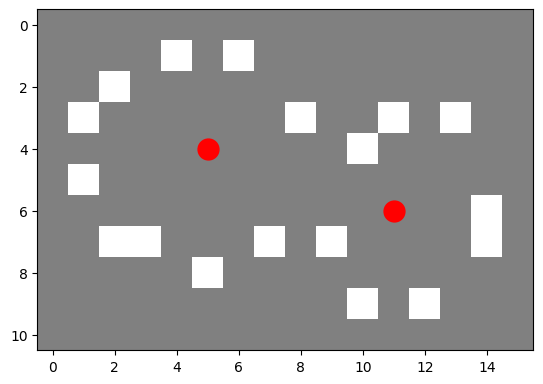

In [111]:
plt.imshow(disconnected_img,cmap='gray',alpha=0.5)
for pair in pd.pairs():
    plt.plot(pair.death_position[1],pair.death_position[0],marker='.',color='red',markersize=30)
plt.show()

We can move on to segmentation using stable volume.

In [121]:
hc.PDList.from_alpha_filtration(pointcloud, 
                                save_to="pointcloud-phtrees.pdgm",
                                no_squared=True,
                                save_phtrees=True,
                                save_boundary_map=True)
phtrees = hc.PDList("pointcloud-phtrees.pdgm").dth_diagram(1).load_phtrees()
stable_volumes = [node.stable_volume(0.01) for node in phtrees.all_nodes if node.lifetime() > 0.5]

In [144]:
h,w=disconnected_img.shape
connected_img=np.zeros((h,w))
for sv in stable_volumes:
    boundary_edges=sv.boundary()
    for i in range (0,len(boundary_edges)):
        cv2.line(connected_img,
                     pt1=(int(boundary_edges[i][0][1]),int(boundary_edges[i][0][0])),
                     pt2=(int(boundary_edges[i][1][1]),int(boundary_edges[i][1][0])),
                     thickness=1,
                     color=(255,255,255),
                     lineType=cv2.LINE_8,
                     shift=0)

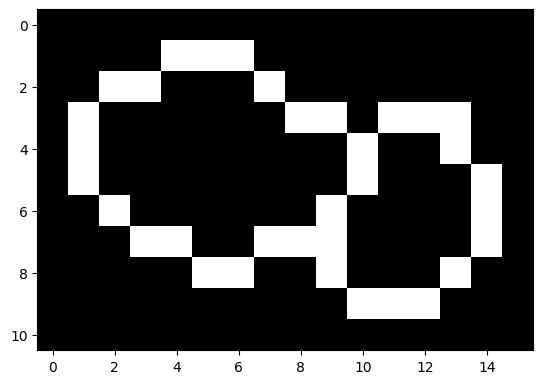

In [145]:
plt.imshow(connected_img,cmap='gray')
plt.show()

In [160]:
ret, bin_img = cv2.threshold(connected_img, 20, 255, cv2.THRESH_BINARY)
n_labels, labels = cv2.connectedComponents((bin_img<150).astype('uint8'),connectivity=4)

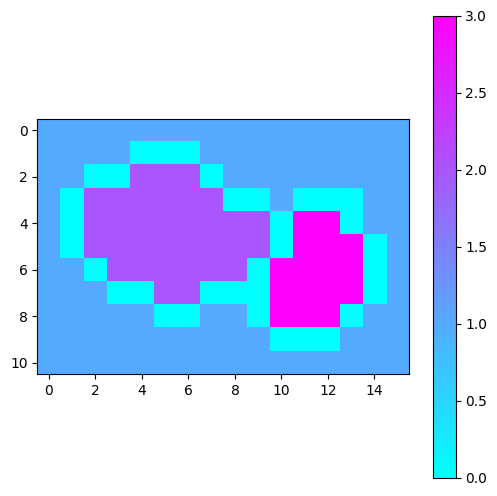

In [167]:
fig, ax = plt.subplots(figsize=(6,6))
im = ax.imshow(labels,cmap='cool')
cbar = fig.colorbar(im)
plt.show()

For the use of stable volume with branch structures, see

https://github.com/TopologicalBird/Connecting_Disconnected_Branch_Persistent_Homology